In [1]:
import json
import numpy as np
import tensorflow as tf
import model.cnn as cnn
import model.rnn as rnn
from model.misc import variable_size_window
import model.classifier as classifier

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_style('dark')
sns.set_context('poster')
%matplotlib inline


In [2]:
cnn_block_params = {
    'dropout': 1,
    'out_dims' : [128, 256, 256],
    'kernel_sizes' : 64,
    'pool_sizes' : 1,
    'RESIDUAL_POOL': 3
  }
fc_params = {
    'fc_sizes': []
}
network_params = {
    'resnet': {
        'avg_pool': True,
        'block_num': 2,
        'block0': cnn_block_params,
        'block1': cnn_block_params
    },
    'partition_num': 5,
    'fc_params': fc_params
}
#print(json.dumps(resnet_params, indent=2, sort_keys=True))


In [3]:
def get_resnet_output(X, params, seq_len=None):
    try:
        resnet_params = params['resnet']
    except KeyError:
        raise ValueError('No "resnet" entry could be found in `params`')
    
    if seq_len is None:
        seq_len_required = False
        seq_len = tf.placeholder(tf.float32, [None], 
                                 name='seq_len_placeholder')
    else:
        seq_len_required = True
    
    avg_pool = resnet_params.get('avg_pool')
    if avg_pool is None:
        avg_pool = False
    
    if avg_pool:
        pool_fn = tf.contrib.layers.avg_pool2d
    else:
        pool_fn = tf.contrib.layers.max_pool2d
    
    block_num = resnet_params['block_num']
    residual_input = X[..., None, None]
    
    for i in range(block_num):
        cnn_block_params = resnet_params['block%d'%i]
        try:
            RESIDUAL_POOL = cnn_block_params['RESIDUAL_POOL']
        except KeyError:
            RESIDUAL_POOL = 1
        if cnn_block_params.get('pool_sizes') is None:
            cnn_block_params['pool_sizes'] = 1
            
        c = cnn.model(
            seq_len=seq_len,
            input_op=residual_input,
            residual=True,
            model_name='CNN_block_%d' % i,
            **cnn_block_params)
        
        residual_input += c.output 
        
        if RESIDUAL_POOL > 1:
            print('%s_POOL_%d--factor-%d' % (
                'AVG' if avg_pool else 'MAX', i, RESIDUAL_POOL))
            residual_input = pool_fn(
                c.output,
                kernel_size=[RESIDUAL_POOL, 1],
                stride=[RESIDUAL_POOL, 1])
        print('')
    res_out = residual_input
    #res_out = tf.squeeze(residual_input, axis=2)
    
    # Instead of global averaging,
    # Use variable sized windows to make equal fractions of input
    # Preserving the raw locality of the features
    # Still it is a fixed length feature representation
    partition_num = params['partition_num']
    partitioned_out = variable_size_window(res_out, partition_num)
    local_features = tf.reduce_mean(partitioned_out, axis=2)
    #out = local_features
    fc_params = params['fc_params']
    classifier_in = tf.contrib.layers.flatten(local_features)
    out = classifier.get_logits_and_pred(classifier_in, return_name=False, **fc_params)
    if seq_len_required:
        return out, seq_len
    return out


In [19]:
with tf.Session() as sess:
    print(tf.constant(5, shape=[3, 5]).eval())

[[5 5 5 5 5]
 [5 5 5 5 5]
 [5 5 5 5 5]]


In [4]:
tf.reset_default_graph()
input_op = tf.placeholder(1, [None, None], 'INPUT')
res_out = get_resnet_output(input_op, network_params)

CNN_block_0--cnn128x64-256x64-256x64
Tensor("CNN_block_0/Conv1/Conv_dim128_ker64_pool1/Relu:0", shape=(?, ?, 1, 128), dtype=float32)
Tensor("CNN_block_0/Conv2/Conv_dim256_ker64_pool1/Relu:0", shape=(?, ?, 1, 256), dtype=float32)
Tensor("CNN_block_0/Conv3/Conv_dim256_ker64_pool1/Relu:0", shape=(?, ?, 1, 256), dtype=float32)
AVG_POOL_0--factor-3

CNN_block_1--cnn128x64-256x64-256x64
Tensor("CNN_block_1/Conv1/Conv_dim128_ker64_pool1/Relu:0", shape=(?, ?, 1, 128), dtype=float32)
Tensor("CNN_block_1/Conv2/Conv_dim256_ker64_pool1/Relu:0", shape=(?, ?, 1, 256), dtype=float32)
Tensor("CNN_block_1/Conv3/Conv_dim256_ker64_pool1/Relu:0", shape=(?, ?, 1, 256), dtype=float32)
AVG_POOL_1--factor-3


FC--fc
Tensor("classifier/logits/BiasAdd:0", shape=(?, 4), dtype=float32)
Tensor("classifier/predictions:0", shape=(?, 4), dtype=float32)


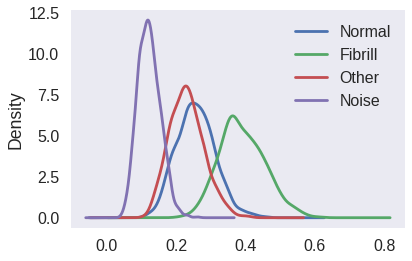

In [13]:
#sns.heatmap(res[1])
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    res = sess.run(res_out, {input_op:np.random.randn(1000, 100)})
df = pd.DataFrame(res[1], columns=['Normal', 'Fibrill', 'Other', 'Noise'])
df.plot.kde()

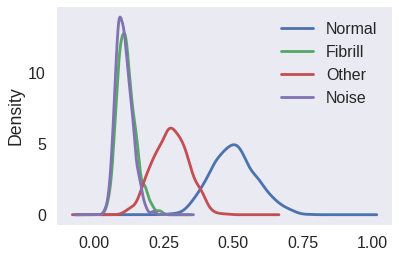

In [16]:
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    #res = sess.run(res_out, {input_op:np.random.randn(1000, 100)})
df = pd.DataFrame(res[1], columns=['Normal', 'Fibrill', 'Other', 'Noise'])
df.plot.kde()

In [8]:
x = tf.placeholder(1, [None, None, 1, None])
def divide_x(x, N):
    with tf.name_scope('sample_division'):
        x_shape = tf.shape(x)
        batch_size, seq_len = x_shape[0], x_shape[1]
        # Make sure sequence can be divided to equal parts
        padding = [[0,0],[0, N-seq_len%N],[0,0], [0,0]]
        x_pad = tf.pad(x, padding, 'SYMMETRIC')
        
        # Don't pad if not necessary, i.e. seq_len%N == 0
        x = tf.cond(tf.equal(seq_len%N, 0), lambda: x, lambda: x_pad)
        seq_len = tf.shape(x)[1]
        div_x = tf.reshape(x, [batch_size, N, seq_len//N, x_shape[-1]])
        return div_x

div_x = divide_x(x, 10)

In [9]:
dim = x.shape[2]
dim.value

1

In [10]:
with tf.Session() as sess:
    res = div_x.eval({x:np.arange(1000*91).reshape(1000, 91, 1, 1)})

In [11]:
#res[0, -1, :, 0]
res.shape

(1000, 10, 10, 1)

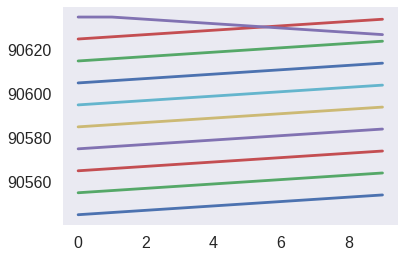

In [12]:
plt.plot(res[-5].squeeze().T)